In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
sys.path.append(os.path.abspath("../src/"))
import model.train_profile_model as train_profile_model
import feature.util as feature_util
import feature.make_profile_dataset as make_profile_dataset
import explain.compute_importance as compute_importance
from deeplift.visualization import viz_sequence
import numpy as np
import pandas as pd
import json

Using TensorFlow backend.
/users/amtseng/miniconda3/envs/tfmodisco/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/users/amtseng/miniconda3/envs/tfmodisco/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/users/amtseng/miniconda3/envs/tfmodisco/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/u

### Define paths for the model and data of interest

In [3]:
# Define the paths to the files and model, and some constants
files_spec_path = "/users/amtseng/tfmodisco/data/processed/ENCODE/config/SPI1/SPI1_training_paths.json"
model_path = "/users/amtseng/tfmodisco/models/trained_models/SPI1_fold1/1/model_ckpt_epoch_1.h5"

reference_fasta = "/users/amtseng/genomes/hg38.fasta"
chrom_sizes = "/users/amtseng/genomes/hg38.canon.chrom.sizes"
input_length = 1346
profile_length = 1000
num_tasks = 4

In [4]:
# Extract the file specs
with open(files_spec_path, "r") as f:
    files_spec = json.load(f)
peak_bed = files_spec["peak_beds"][0]  # First peaks BED, arbitrarily
profile_hdf5 = files_spec["profile_hdf5"]

In [5]:
# Import the model
model = train_profile_model.load_model(model_path, num_tasks, profile_length)







Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Data preparation
Use classes from `make_profile_dataset` to prepare positive and negative inputs.

In [6]:
# Maps coordinates to 1-hot encoded sequence
coords_to_seq = feature_util.CoordsToSeq(reference_fasta, center_size_to_use=input_length)

# Maps coordinates to profiles
coords_to_vals = make_profile_dataset.CoordsToVals(profile_hdf5, profile_length)

# Maps many coordinates to inputs sequences and profiles for the network
def coords_to_network_inputs(coords):
    input_seq = coords_to_seq(coords)
    profs = coords_to_vals(coords)
    return input_seq, np.swapaxes(profs, 1, 2)

In [7]:
# Import set of positive peaks
pos_coords_table = pd.read_csv(peak_bed, sep="\t", header=None, compression="gzip")

### Compute SHAP scores

In [8]:
pos_sample = pos_coords_table.sample(10).values[:, :3]
input_seqs, profs = coords_to_network_inputs(pos_sample)
cont_profs = profs[:, num_tasks:, :, :]

In [9]:
prof_explainer = compute_importance.create_explainer(model, output_type="profile")
prof_scores = prof_explainer(input_seqs, cont_profs)

In [10]:
count_explainer = compute_importance.create_explainer(model, output_type="count")
count_scores = count_explainer(input_seqs, cont_profs)

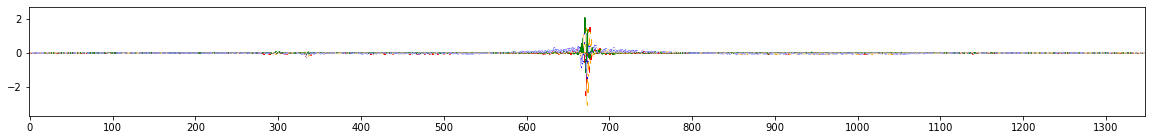

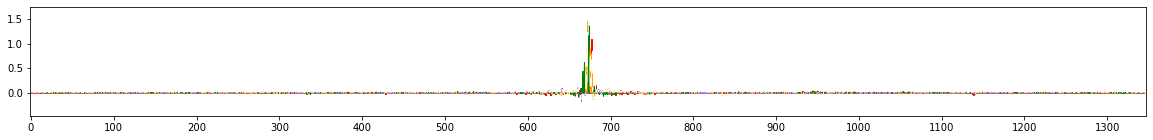

In [11]:
# Profile importance scores
viz_sequence.plot_weights(prof_scores[0], subticks_frequency=100)
viz_sequence.plot_weights(prof_scores[0] * input_seqs[0], subticks_frequency=100)

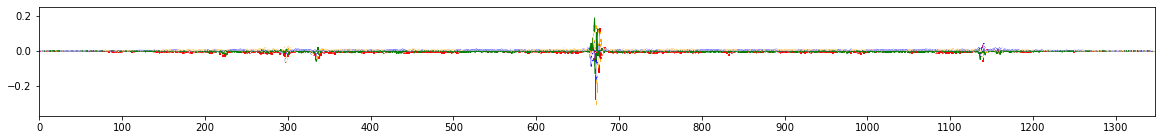

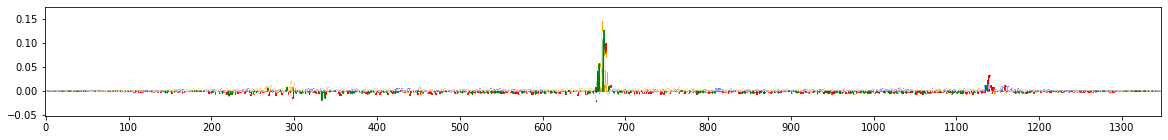

In [12]:
# Count importance scores
viz_sequence.plot_weights(count_scores[0], subticks_frequency=100)
viz_sequence.plot_weights(count_scores[0] * input_seqs[0], subticks_frequency=100)